## How do weather conditions affect NYC subway ridership?

*Updated: 09 Nov 2015*

---

First, let's import the data and set it up for analysis.

In [87]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pylab
from ggplot import *
from scipy import stats
import statsmodels.api as sm
from datetime import datetime

# set graphing to inline
%matplotlib inline

In [134]:
# import data
df = pd.read_csv('nyc_subway_weather_data_master.csv')

# drop old index values that are coming in as distinct columns
df.drop(df.columns[[0, 1]], axis=1, inplace=True)

In [141]:
# list columns and data types
df.dtypes

UNIT                object
DATEn               object
TIMEn               object
Hour                 int64
DESCn               object
ENTRIESn_hourly    float64
EXITSn_hourly      float64
maxpressurei       float64
maxdewpti          float64
mindewpti          float64
minpressurei       float64
meandewpti         float64
meanpressurei      float64
fog                float64
rain               float64
meanwindspdi       float64
mintempi           float64
meantempi          float64
maxtempi           float64
precipi            float64
thunder            float64
dtype: object

In [142]:
# simple rename to make things easier later
df.rename(columns = {'Hour':'hour'}, inplace = True)

# peek at data
df.head(2)

,UNIT,DATEn,TIMEn,hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,mindewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,35,...,39,30.27,0,0,5,50,60,69,0,0
1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,35,...,39,30.27,0,0,5,50,60,69,0,0


In [143]:
# generate boolean to indicate weekday / weekend

# convert date string to datetime
df['date'] = df.DATEn.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# generate weekday boolean
df['weekday'] = df.date.apply(lambda x: np.where((x.weekday() == 5)\
                                               | (x.weekday() == 6), 0, 1))

### Statistical test of difference between rain and no-rain groups

Let's see if there is a statistically significant difference between the rain and no-rain groups when it comes to ridership. First step is to look at the shape of the two distributions.

In [136]:
# summary statistics for the rain and no-rain groups
df[['ENTRIESn_hourly', 'rain']].groupby('rain').describe()

ENTRIESn_hourly
rain                       
0    count     87847.000000
     mean       1090.278780
     std        2320.004938
     min           0.000000
     25%          38.000000
     50%         278.000000
     75%        1111.000000
     max       43199.000000
1    count     44104.000000
     mean       1105.446377
     std        2370.527674
     min           0.000000
     25%          41.000000
     50%         282.000000
     75%        1103.250000
     max       51839.000000

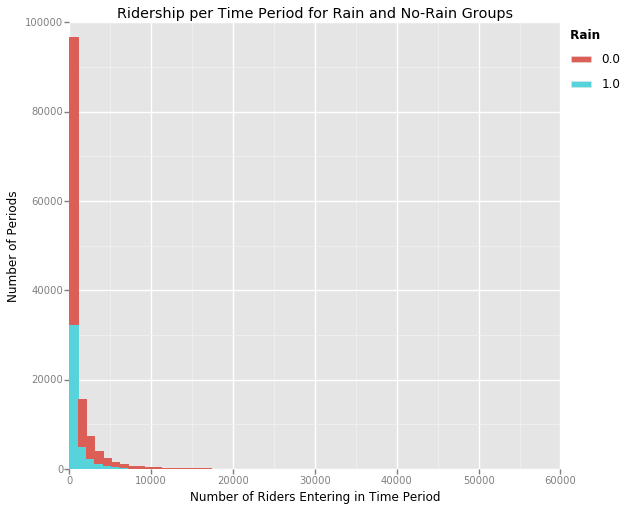

<ggplot: (281423049)>

In [144]:
# plot histograms showing ridership per period for rain (rain=1)and 
# no-rain (rain=0) groups

ggplot(aes(x='ENTRIESn_hourly', fill='rain', color='rain'), data=df) + \
    geom_histogram(binwidth=1000) + \
    ggtitle('Ridership per Time Period for Rain and No-Rain Groups') + \
    ylab('Number of Periods') + \
    xlab('Number of Riders Entering in Time Period')

What we see here is that the rain and no-rain groups have similarly-shaped distributions. Obviously, the no-rain distribution is taller, but otherwise the two have similar long-tailed shapes, suggesting that time periods experiencing high rider entries are rarer than time periods experiencing low rider entries, independent of whether rain occurred on the day in question.

That the distributions are non-normal is important because it influences the type of statistical test we can apply when we test for difference. Let's confirm this by applying a Shapiro-Wilk Test of normality.

In [145]:
# Shapiro-Wilk Test of normality for rain group

df_rain = df['ENTRIESn_hourly'][df['rain']==1]
print "N =", len(df_rain)

w, p = stats.shapiro(df_rain)
print "p =", p
print "p-crit = 0.05"

N = 44104
p = 0.0
p-crit = 0.05


The p-value of our test is lower than p-critical, leading us to reject our null hypothesis of normality.

One hiccup here is that the population of this group is so large (N = 21,975) that even very small deviations from normality end up leading us to reject the null hypothesis. Nevertheless, from the plot of overlaid histograms above, we can clearly see that the distributions are not normal, so we don't need to worry about this here.

Now that we know more about the shape of the distributions, we can proceed to test for difference. Given that neither distirbution is normal, I will apply the **Mann-Whitney U Test**, which is a non-parametric test.

Test details:  
- **Null Hypothesis:** A random draw from the 'rain' population is not likely to produce a higher or lower mean than a random draw from the 'no rain' population.  
- **Alternative Hypothesis:** A random draw from the 'rain' population is likely to produce a higher or lower mean than a random draw from the 'no rain' population.  
- **P critical value** = 0.05

In [146]:
# Mann-Whitney Test of difference

df_rain = df['ENTRIESn_hourly'][df['rain']==1]
df_no_rain = df['ENTRIESn_hourly'][df['rain']==0]
u, p = stats.mannwhitneyu(df_rain, df_no_rain)

print "Two-sided p-value: ", (p*2), "\n"
print "Median rain: ", df_rain.median()
print "IQR rain: ", np.subtract(*np.percentile(df_rain, [75, 25])), "\n"
print "Median no-rain: ", df_no_rain.median()
print "IQR no-rain: ", np.subtract(*np.percentile(df_no_rain, [75, 25]))

Two-sided p-value:  0.049999825587 

Median rain:  282.0
IQR rain:  1062.25 

Median no-rain:  278.0
IQR no-rain:  1073.0


Given that the two-sided p-value generated by our test (0.049999825587) is lower than our p-critical value (0.05), we reject the null hypothesis. With 95% confidence, we can say that random samples drawn from the rain and no-rain populations will produce distinct distributions with distinct means, suggesting that there is a real difference in the number of riders who use the subway when it rains compared to when it does not rain.

---

### Linear Regression

Let's build a model to explain variation in ridership, drawing on some key meteorological variables in combination with some other stuff we have available in this dataset.

First let's explore some key contenders for inclusion in the model, starting with time of day to get a sense of fluctionation in traffic over the course of the day, broken out by weekdays and weekend days.

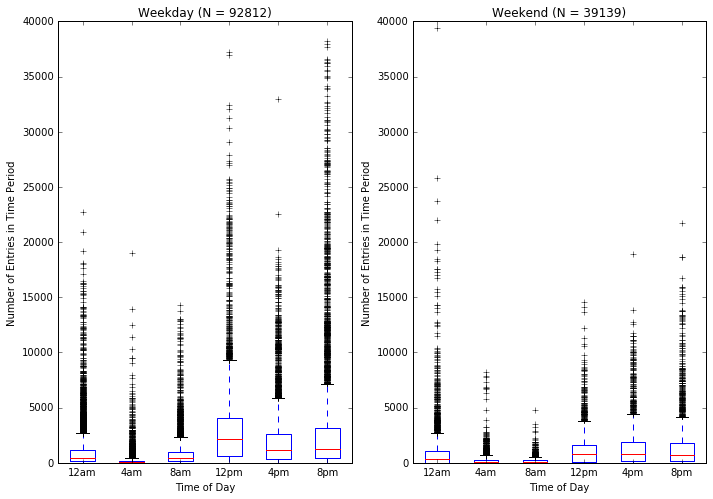

In [147]:
# plot showing relationship between ridership and time of day on
# weekdays vs weekend days

# let's get a quick sense of distribution of ridership by time of day
# by sampling at regular intervals across day

# weekday
df_temp1 = df[df['weekday']==1]
hour_0 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==0]
hour_4 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==4]
hour_8 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==8]
hour_12 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==12]
hour_16 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==16]
hour_20 = df_temp1['ENTRIESn_hourly'][df_temp1['hour']==20]
temp1 = [hour_0, hour_4, hour_8, hour_12, hour_16, hour_20]

# weekend
df_temp2 = df[df['weekday']==0]
hour2_0 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==0]
hour2_4 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==4]
hour2_8 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==8]
hour2_12 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==12]
hour2_16 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==16]
hour2_20 = df_temp2['ENTRIESn_hourly'][df_temp2['hour']==20]
temp2 = [hour2_0, hour2_4, hour2_8, hour2_12, hour2_16, hour2_20]

# x-axis labels
labels = ['12am', '4am', '8am', '12pm', '4pm', '8pm']

# create figure
fig = plt.figure(figsize=(10,7))

# first sub-plot

ax1 = fig.add_subplot(121)
plt.boxplot(temp1, labels=labels)
plt.title('Weekday (N = %d)' % len(df_temp1))
plt.xlabel("Time of Day")
plt.ylabel("Number of Entries in Time Period")

# second sub-plot
ax2 = fig.add_subplot(122)
plt.boxplot(temp2, labels=labels)
plt.title('Weekend (N = %d)' % (len(df_temp2)))
plt.xlabel("Time of Day")
plt.ylabel("Number of Entries in Time Period")
plt.ylim(0,40000)  # standardize y-axis using upper y-axis limit of first plot

fig.tight_layout()
fig.show()

Comparing the two plots, we see that the daytime (8am-8pm) means are higher for weekdays than for weekends. We also see that the inter-quartile range is much larger for daytimes periods on weekdays than for other times of day and for weekends, suggesting that while on average units see higher entries during daytime on weekdays than otherwise, there is considerable variation across units and across days when it comes to weekday daytime entries. This is further supported by the huge number and extensive reach of positive outliers for weekday daytime periods. 

Unsurprisingly, for both weekday and weekend plots, we see substantial variation across times of day, with the 4am and 8am periods recording lower average entries than daytime periods. This suggests that ridership is systematically lower in the middle of the night and eary in the morning than it is during the daytime or at midnight. 

Together, this suggests that we should include a weekday/weekend boolean, a time of day variable, and station-specific dummies in the first go of our model.

---

In [148]:
# create 'peak' hours boolean to distinguish peak from off-peak, with different 
# peak bands for weekday and weekend

df['peak'] = np.where(((df['weekday']==0) & (df['hour']>8) | (df['hour']<4)) |\
                      ((df['weekday']==1) & (df['hour']>8)), 1, 0)

In [149]:
# generate list of features and accompanying values for linear regression,
# then execute regression

# values
values = df['ENTRIESn_hourly']

# features
features = df[['precipi',      # precipitation in inches at the time and location
              'meanwindspdi',  # wind speed in miles per hour at the time and location
              'peak']]         # boolean to indicate peak/non-peak time of day

# create and join dummies for individual stations (or 'units' as they are referred to
# in the dataset) 
d_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(d_units)

# execute linear regression
features = sm.add_constant(features)
est = sm.OLS(values, features).fit()

My model includes the following features:
  * **precipi -- Precipitation in inches at the time and location** -- In exploratory analysis, I noticed that the 'precipi' variable outperformed the 'rain' boolean variable in explaining variation in ridership rates, likely because the 'precipi' variable is a continuous variable that provides precise information about the amount of precipitation at the specified point in time, whereas the 'rain' variable is a boolean variable that offers no insight into the _amount_ of precipitation experienced and that is, moreover, coded at the DAY level rather than the 4-hour level at which ridership data is coded. For these reasons, the 'precipi' variable made for a stronger precipitation variable to be used in my model.;
  * **wspdi -- Wind speed in miles per hour at the time and location** -- In exploratory analysis, I observed that this variable helped explain variation in ridership;
  * ** peak -- A boolean variable that I created to distinguish between peak and off-peak usage periods**; and
  * **dummy vairables for each of the units.**

In [150]:
# print model output

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     244.0
Date:                Wed, 11 May 2016   Prob (F-statistic):               0.00
Time:                        06:13:12   Log-Likelihood:            -1.1695e+06
No. Observations:              131951   AIC:                         2.340e+06
Df Residuals:                  131483   BIC:                         2.345e+06
Df Model:                         467                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const          491.6565     16.803     29.261   

The model explains 46.4% of variation in ridership, which is pretty good given how few features we have included in the model.

But how appropriate is a linear model here? Below I include two plots showing the distribution of the residuals, both of which suggest that a linear model is not appropriate to explain variability in ridership. The probability plot below shows that residuals in the upper quantiles are far from what we would expect were residuals to be normally distributed. This suggests that my model is missing some important features, polynomial inputs, and/or interaction terms -- work for a future iteration!

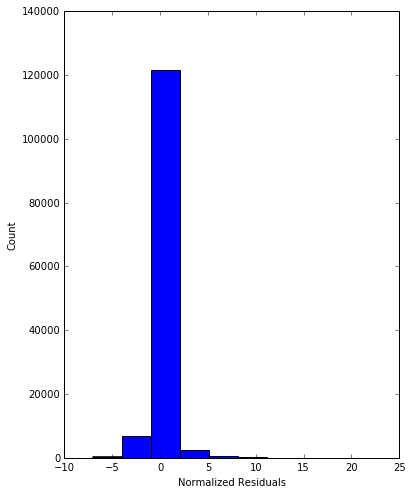

In [151]:
# histogram of the normalized residuals

plt.figure(figsize=(6,8))
plt.hist(est.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Normalized Residuals')

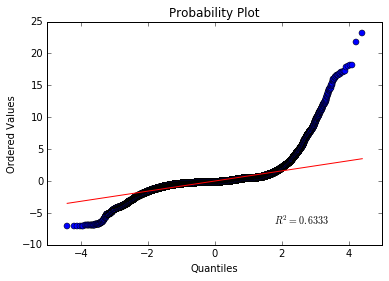

In [152]:
# probability plot of residuals

stats.probplot(est.resid_pearson, dist="norm", plot=pylab)
pylab.show()

---

### Conclusion

Overall, my analysis suggests that precipitation increases ridership on NYC's subway system.

Results from the Mann-Whitney U Test suggest that, with 95% confidence, we can say that the distribution of ridership is different for 'rain' and 'no rain' periods. The Mann-Whitney U Test cannot, on its own, tell us whether one population has a higher mean than the other, but instead only that the two means are statistically different. Looking at the means of the two populations, we see that ridership is higher, on average, when it rains than when it doesn't rain.

The linear regression results show that, when we control for unit, wind speed, and peak/off-peak, an increase in precipitation is positively associated with ridership, and that this relationship is statistically significant at p >= 0.05 level.

The dataset used for this analysis suffers from several shortcomings. First, for each unit, we have only five measures per day, which leaves much of the day unobserved. This lack of granularity means that we might be missing some important insights into how variables relate to one another. Second, the dataset lacks data on a number of contextual factors that we can hypothesize would have an impact on ridership. For example, it does not indicate when significant events occurred in the calendar, such as non-weekend holidays or big sporting events, each of which likely has a big impact on ridership for the relevant time periods. Without data on such events, we cannot include such features in our model, and without these features, the associated variability observed in the data shows up as noise that the model cannot explain. Third, the dataset contains no data on unit closures, despite the fact that this can have a dramatic impact on entries at the given unit -- for example, when a unit is closed for construction or repair, it logs no entries, yet we have no way of knowing that the lack of entries was driven by closure/repair because the dataset does not track this factor.

For my analysis, I did not explore the possibility of interactions between features, and did not explore the relationship between ridership and **polynomial** renderings of the variables for which we have data. Instead, I considered only linear relationships between the dependant and independent variables. Future iterations will explore these options.

---